SerialException: read failed: [Errno 6] Device not configured

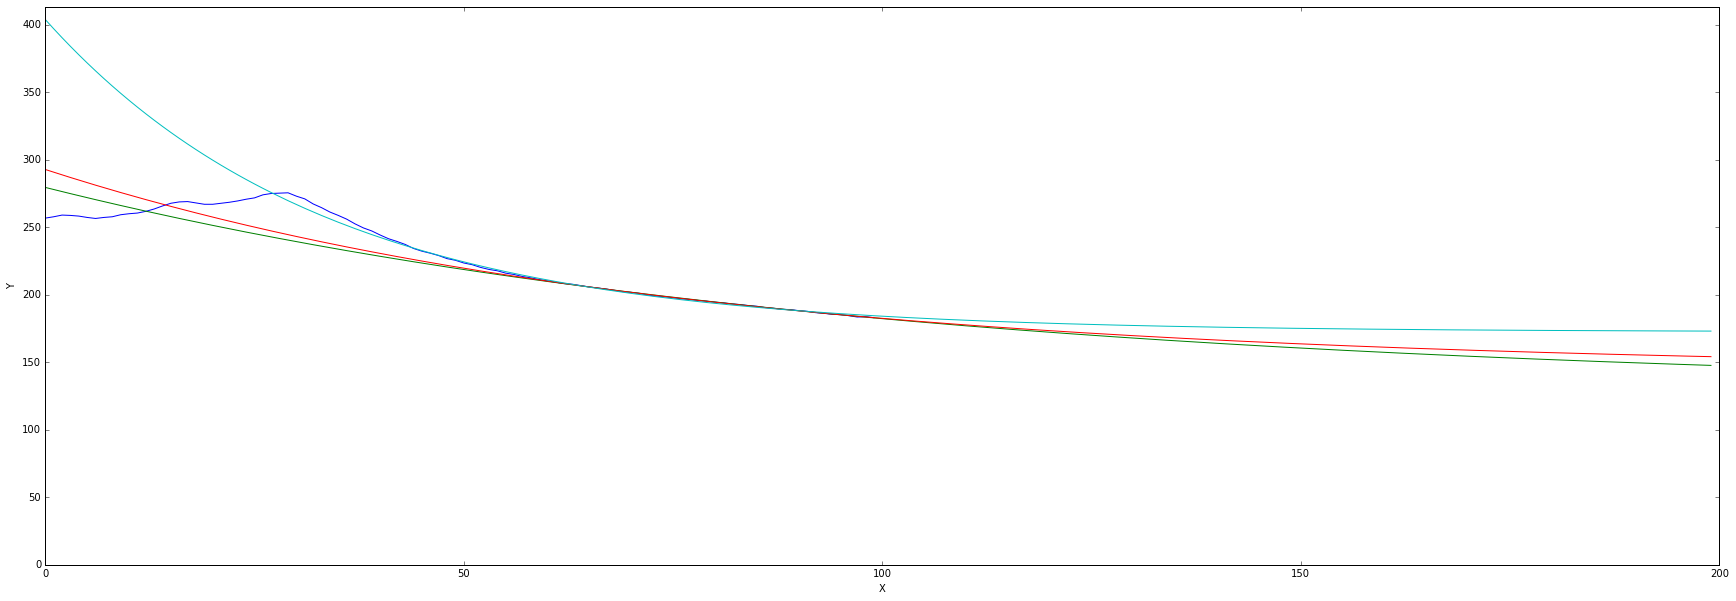

In [52]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
from IPython import display
%matplotlib inline
from math import pi, sin
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = (30.0, 10.0)


N = 100
import serial
def temp_stream(dummy = False):
    if dummy:
        t0 = time.time()
        while True:
            t = time.time() - t0
            #simulate a blocking method that only returns data every so often
            time_until_reading = t % 0.05
            time.sleep(time_until_reading)
            T0 = 10 #degrees C
            tau = 4 #decay time in seconds
            
            yield T0*(1 - exp(-t / tau))  + 0.1*np.random.randn(1)#0.5Hz sine wave
            #yield sin(time.time() * 2* pi * 0.2)  + 0.1*np.random.randn(1)#0.5Hz sine wave
    else:
        with serial.Serial('/dev/cu.wchusbserial1410', 9600, timeout = 5) as ser:
            while True:
                temp, time =  map(float, ser.readline().split())
                yield temp
        
        
        
def estimate(data, M):
    def func(t, T0, tau, Tc):
        #T0 is the equilibrium temp
        #tau is the decay time
        #t0 is the initial time
        return T0 + (Tc - T0) * np.exp(-t / tau)
    try:
        popt, pcov = curve_fit(func, np.arange(N - M, N), np.array(data)[-M:], p0=(data[-1],20,data[-M]))
    except:
        return np.zeros(2*N)
    return func(np.arange(0,2*N), *popt)



def realtime_plot(ax, *data):
    if len(ax.lines):
        for line, datum in zip(ax.lines, data):
            x,y = datum
            line.set_ydata(y)
            line.set_xdata(x)
        
        ax.set_ylim(0,max(data[0][1]) * 1.5)
    else:
        for x,y in data:
            ax.plot(x,y)
    fig.canvas.draw()


from collections import deque
data = deque(np.zeros(N), maxlen = N)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,2*N)


for datum in temp_stream():
    try:
        data.append(datum)
        
        realtime_plot(ax, [np.arange(0, N), data],
                  [np.arange(0, 2*N), estimate(data, 20)],
                  [np.arange(0, 2*N), estimate(data, 40)],
                  [np.arange(0, 2*N), estimate(data, 60)])
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except KeyboardInterrupt:
        print("Interupted")
        break


In [12]:
np.arange(5, 10)

array([5, 6, 7, 8, 9])